# Predicting the Beats-per-Minute of Songs. Classic ML approaches vs FT-Transformer.
# 2. CatBoost


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from catboost import CatBoostRegressor, Pool



plt.style.use('ggplot')

First, we will load and prepare the data. During evaluation of previous models, we observed that the data contains significant noise and outliers. To partially solve these issues, we will apply the Interquartile Range (IQR) method.   

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/BPM detection/train.csv').drop('id', axis=1)
train_orig_data = pd.read_csv('/content/drive/MyDrive/BPM detection/train_orig.csv')

train_data = pd.concat([train_data, train_orig_data], ignore_index=True)
test_data = pd.read_csv('/content/drive/MyDrive/BPM detection/test.csv')


q1, q2 = train_data['BeatsPerMinute'].quantile(0.275), train_data['BeatsPerMinute'].quantile(0.725)
iqr = q2 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q2 + 1.5 * iqr

train_data = train_data[(train_data['BeatsPerMinute'] < upper_bound) & (train_data['BeatsPerMinute'] > lower_bound)]

In [ ]:
train_data

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.530200
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.159630
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.912120
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.585110
5,0.594579,-11.715431,0.101701,0.000005,0.259634,0.024300,0.639254,161012.2221,0.938333,151.436020
...,...,...,...,...,...,...,...,...,...,...
538792,0.769195,-13.608768,0.041826,0.551064,0.127238,0.024300,0.508722,223465.5814,0.473600,82.317428
538793,0.267248,-8.657102,0.023500,0.218652,0.161223,0.287364,0.763650,135276.0877,0.148467,132.107938
538794,0.469302,-1.961814,0.023500,0.912164,0.152560,0.227046,0.619231,134735.8587,0.423133,83.344250
538795,0.588335,-9.766187,0.023500,0.000005,0.050234,0.340709,0.177841,187951.2290,0.340000,121.297185


Splitting the dataset on train/val.


In [ ]:
X = train_data.drop(['BeatsPerMinute'], axis=1)
y = train_data['BeatsPerMinute']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=113)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

First of all, considering the noiseness of the dataset, we will try models with small depth value.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 25.1949434	test: 25.2653044	best: 25.2653044 (0)	total: 112ms	remaining: 1m 40s
100:	learn: 25.1865302	test: 25.2595910	best: 25.2595910 (100)	total: 13.3s	remaining: 1m 45s
200:	learn: 25.1812341	test: 25.2576125	best: 25.2576125 (200)	total: 26.4s	remaining: 1m 31s
300:	learn: 25.1767653	test: 25.2569750	best: 25.2569750 (300)	total: 39.8s	remaining: 1m 19s
400:	learn: 25.1727750	test: 25.2567261	best: 25.2567261 (400)	total: 53.3s	remaining: 1m 6s
500:	learn: 25.1690069	test: 25.2565017	best: 25.2565017 (500)	total: 1m 6s	remaining: 53.1s
600:	learn: 25.1653348	test: 25.2565111	best: 25.2564242 (541)	total: 1m 19s	remaining: 39.8s
700:	learn: 25.1618508	test: 25.2566477	best: 25.2564242 (541)	total: 1m 33s	remaining: 26.6s
800:	learn: 25.1584327	test: 25.2567597	best: 25.2564242 (541)	total: 1m 47s	remaining: 13.2s
899:	learn: 25.1550989	test: 25.2567893	best: 25.2564242 (541)	total: 2m	remaining: 0us

bestTest = 25.25642422
bestIteration = 541

Shrink model to first 542 i

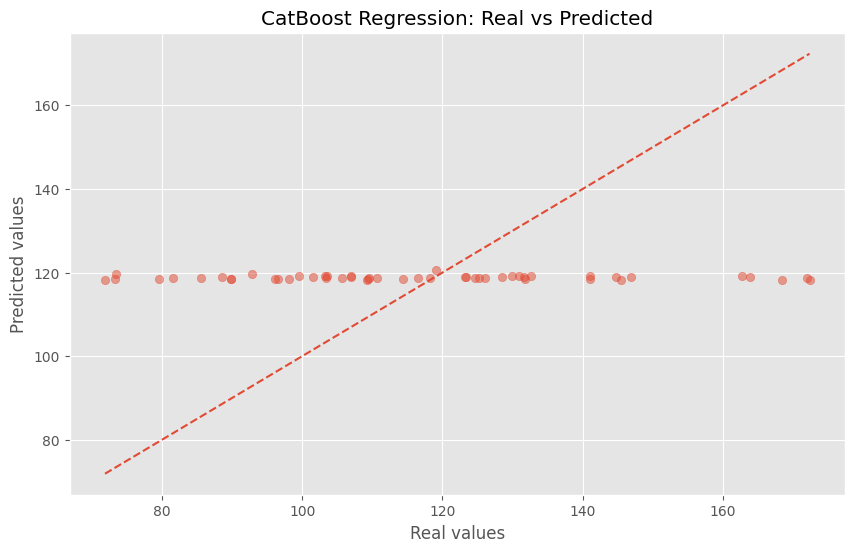

In [ ]:
train_pool = Pool(X_train_scaled, y_train, cat_features=None)
val_pool = Pool(X_val_scaled, y_val, cat_features=None)

model = CatBoostRegressor(
    iterations = 541,
    learning_rate=0.015,
    depth=3,
    l2_leaf_reg=6,
    loss_function='RMSE',
    grow_policy = 'Depthwise',
    eval_metric='RMSE',
    random_seed=113,
    verbose=100,
    early_stopping_rounds=500,
    min_data_in_leaf = 10,
    bagging_temperature=0.1
)

model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    plot=True
)

y_pred = model.predict(X_val_scaled)

print(f"MSE: {mean_squared_error(y_val, y_pred):.5f}")
print(f"R-squared: {r2_score(y_val, y_pred):.5f}")
print(f"MAE: {mean_absolute_error(y_val, y_pred):.5f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_val[:50], y_pred[:50], alpha=0.5)
plt.plot([y_val[:50].min(), y_val[:50].max()], [y_val[:50].min(), y_val[:50].max()], '--')
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("CatBoost Regression: Real vs Predicted")
plt.show()



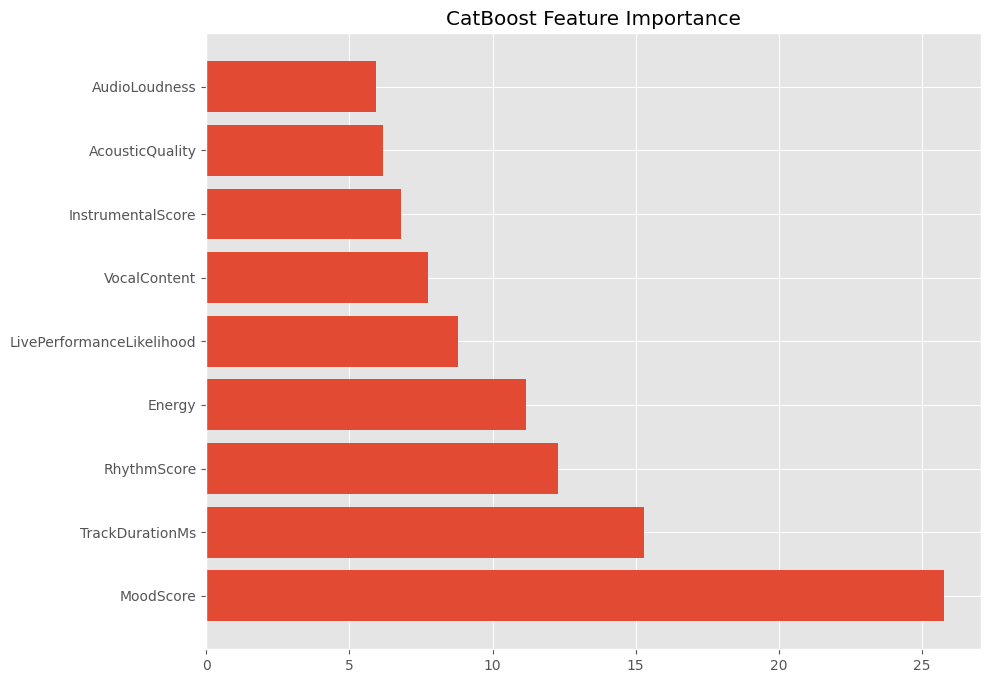

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
features = X_train.columns[sorted_idx]

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), features)
plt.title("CatBoost Feature Importance")
plt.show()

Other models:

*   RMSE=26.43126885, iterations = 307, lr = 0.025, depth = 5, l2_reg = 4.
*   RMSE = 25.25699156, iterations = 422, lr = 0.015, depth = 4, l2_reg = 5.
*   RMSE = 25.25661359, iterations = 900, lr = 0.015, depth = 3, l2_reg = 6. (Best Public Score in Kaggle within my tries)
*   RMSE = 25.25660821, iterations = 307, lr = 0.07, depth = 11, l2_reg = 6, depthwise growth and bagging.




Secondly, we will test models with higher depths. The final model will be obtained by averaging the previous and above described models.

In [ ]:
second_model = CatBoostRegressor(
    iterations = 900,
    learning_rate=0.0078,
    depth=10,
    l2_leaf_reg=0.3,
    loss_function='RMSE',
    grow_policy = 'Lossguide',
    eval_metric='RMSE',
    random_seed=123,
    verbose=100,
    early_stopping_rounds=500,
    min_data_in_leaf = 10,
    bagging_temperature=0.5
)

second_model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    plot=True
)

y_pred_second = second_model.predict(X_val_scaled)

print(f"MSE: {mean_squared_error(y_val, (y_pred + y_pred_second)/2):.5f}")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 25.1949139	test: 25.2652731	best: 25.2652731 (0)	total: 327ms	remaining: 4m 54s
100:	learn: 25.1852925	test: 25.2599922	best: 25.2599922 (100)	total: 19.8s	remaining: 2m 36s
200:	learn: 25.1784406	test: 25.2580053	best: 25.2580053 (200)	total: 37.8s	remaining: 2m 11s
300:	learn: 25.1726492	test: 25.2573149	best: 25.2573149 (300)	total: 57.1s	remaining: 1m 53s
400:	learn: 25.1671654	test: 25.2569989	best: 25.2569980 (399)	total: 1m 14s	remaining: 1m 32s
500:	learn: 25.1619859	test: 25.2567260	best: 25.2566887 (486)	total: 1m 31s	remaining: 1m 12s
600:	learn: 25.1569360	test: 25.2564865	best: 25.2564740 (595)	total: 1m 48s	remaining: 54.2s
700:	learn: 25.1519023	test: 25.2564335	best: 25.2564290 (692)	total: 2m 7s	remaining: 36.2s
800:	learn: 25.1468950	test: 25.2564920	best: 25.2563666 (715)	total: 2m 24s	remaining: 17.8s
899:	learn: 25.1420382	test: 25.2566020	best: 25.2563666 (715)	total: 2m 39s	remaining: 0us

bestTest = 25.25636656
bestIteration = 715

Shrink model to firs

# Results:

In [ ]:
print(f"Final Model, MSE: {mean_squared_error(y_val, (0.5 * y_pred + 0.5 * y_pred_second)):.5f}")
print(f"First Model, MSE: {mean_squared_error(y_val, y_pred):.5f}")
print(f"Second Model, MSE: {mean_squared_error(y_val, y_pred_second):.5f}")

Final Model, MSE: 637.88204
First Model, MSE: 637.88696
Second Model, MSE: 637.88405


In [ ]:
X_test = test_data.drop('id', axis=1).to_numpy()

y_test_pred = (model.predict(X_test) + second_model.predict(X_test))/2

submission = pd.DataFrame()
submission['id'] = test_data['id']
submission['BeatsPerMinute'] = y_test_pred

submission.to_csv('submission.csv', index=False)